In [1]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

# Weather radar image

In [3]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In this exercise I will study a polynomial fit to a radar image of precipitation. The image was captured using my own module nedborradar.py which connects to:https://kartkatalog.geonorge.no/metadata/meteorologisk-kartinformasjon/c247f4a3-56a8-49fa-afe0-a0329b9453e1 and downloads a weather radar image for Eastern Norway. 

The image is then converted to grayscale using my own algorithm where the different shades of blue are assigned values between 0 and 1. No rain is represented by 0 and 1 represents an ammount slightly more than this snapshot's maximum rain. Given that the differnt shades of blue are linearly related to the real measured radar reflectivity, this conversion should work after the data is scaled. Note that chances are that the shades of blue are not linearly related to the radar reflectivity. This could cause an error in my data. However, the data looks good enought for this exercise so I will continue with this error source in mind:) Hopefully I will have had the time to dive into this problem until the next project. 

In [4]:
# The following code downloads a new snapshot of precipitation from the weather radar
# import nedborradar
# import skimage
#x = nedborradar.RadarImage('Eastern Norway')
#Forbedring: Røde flekker for høy nedbørintensitet fanges ikkje opp. !
#norge_radar = x.get_map()
#radar = x.get_grayscale()
#np.save("nedbor_radar.npy", radar)
#np.save("Norge radar.npy", norge_radar)

In [5]:
# In this example we just load an old example event: 
radar = np.load("nedbor_radar.npy") # from 2021-10-06 kl 11:45

### Plot rain and a map over Oslo

This snapshot was taken on a rainy day in Oslo (2021-10-06 kl 11:45). From the weather radar image it could look like it is was not raining in Oslo at that time. However, I could definitely see rain outside my window in Pilestredet. This is in agreement with i.e: https://www.sciencedirect.com/science/article/abs/pii/S0309170812001157 where it is indicated that weather radar has large error-rates, especially for low rain-rates. 

![Precipitation over Oslo region](bilde_norge.png)

### Plot grayscale rain

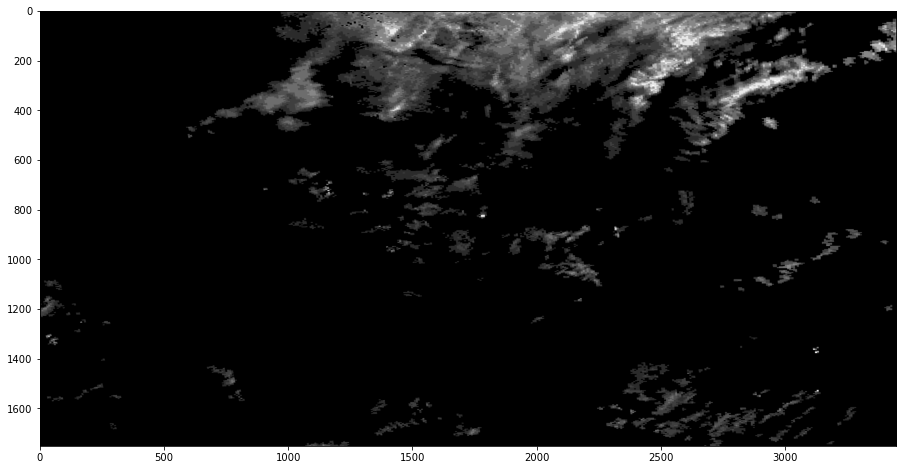

In [6]:
fig, ax = plt.subplots(figsize=(20,8))
ax.imshow(radar, cmap='gray')
plt.show()

### Reduce resolution of image

The downloaded image is way to large for my functions. In this step I therefore reduce the radar image resolution. An interesting consequence of this reduction is that for small scale factors the MSE_train explodes for large polynomials, while for large scale factors it seems like MSE test does not explode. 

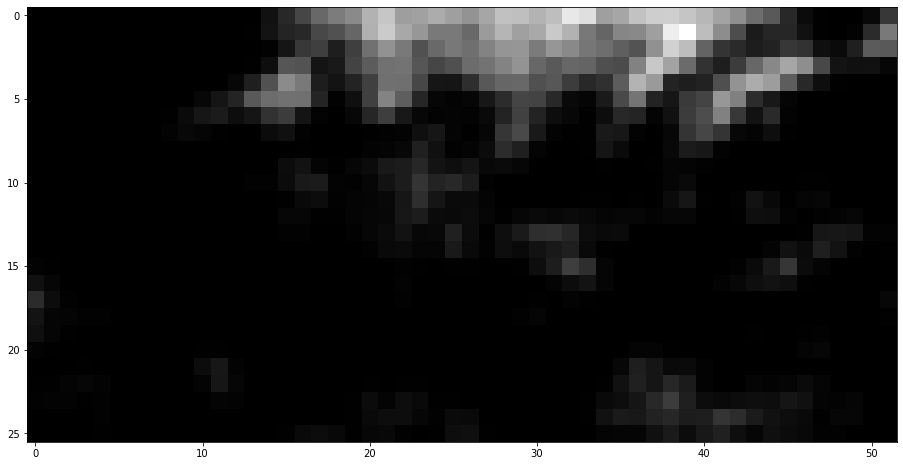

In [7]:
from skimage.transform import rescale
scale_factor = 0.015 # 0.03 gives over-fitting tendencies
radar_rescaled = rescale(radar, scale_factor)

fig, ax = plt.subplots(figsize=(20,8))
ax.imshow(radar_rescaled, cmap='gray')
plt.show()

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm # progressbar

# my own library
from regression import OLS
from regression import Ridge

#sk-learn linear regression for lasso analysis
from sklearn.linear_model import Lasso as Lasso_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

z = radar_rescaled
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

poly = 30
k_folds = 7

MSE_test_OLS = [] 
MSE_train_OLS = []
betas_OLS = []

MSE_test_Ridge = [] 
MSE_train_Ridge = []
betas_Ridge = []
MSE_test_Ridge_l = [] 
MSE_train_Ridge_l = []
betas_Ridge_l = []

MSE_test_Lasso = [] 
MSE_train_Lasso = []
betas_Lasso = []
MSE_test_Lasso_l = [] 
MSE_train_Lasso_l = []
betas_Lasso_l = []

#Scale data
x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

# Cross validation:
# shuffle data:
order = np.arange(x_cent.shape[0]) # number of z-values
np.random.shuffle(order)
x_cent_ = x_cent[order].ravel().reshape(-1,1)
y_cent_ = y_cent[order].ravel().reshape(-1,1)
z_cent_ = z_cent[order].ravel().reshape(-1,1)
xyz_shuffle = np.hstack([x_cent_, y_cent_, z_cent_])
xyz_folds = np.array_split(xyz_shuffle, k_folds) # split into k-folds

for k in tqdm.tqdm(range(k_folds)):     
    # extract folds
    xyz_test = xyz_folds[k] # k-th fold is test 
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold

    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    # OLS:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    for poly_deg in range(1, poly + 1):
        model = OLS(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg)
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_OLS.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
    MSE_test_OLS.append(MSE_test) 
    MSE_train_OLS.append(MSE_train)
    betas_OLS.append(beta_poly) 


    # Ridge:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_ridge = 0.05
    for poly_deg in range(1, poly + 1):
        model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge) 
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
    MSE_test_Ridge.append(MSE_test) 
    MSE_train_Ridge.append(MSE_train)
    betas_Ridge.append(beta_poly) 
  
    # Ridge, lower lambda:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_ridge = 0.025
    for poly_deg in range(1, poly + 1):
        model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge) 
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
    MSE_test_Ridge_l.append(MSE_test) 
    MSE_train_Ridge_l.append(MSE_train)
    betas_Ridge_l.append(beta_poly) 
    
    # Lasso:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_lasso = 0.05
    iterations = 10000
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Lasso_skl(
            alpha=lambda_lasso, fit_intercept=False, max_iter=iterations)).fit(xy_train, z_train.reshape(-1, 1))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = model_skl.steps[1][1].coef_
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan  
        MSE_test.append(np.mean((model_skl.predict(xy_test).ravel() - z_test.ravel())**2)) 
        MSE_train.append(np.mean((model_skl.predict(xy_train).ravel() - z_train.ravel())**2)) 

    MSE_test_Lasso.append(MSE_test) 
    MSE_train_Lasso.append(MSE_train)
    betas_Lasso.append(beta_poly) 
    
    # Lasso, lower lambda: 
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_lasso = 0.025
    iterations = 10000
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Lasso_skl(
            alpha=lambda_lasso, fit_intercept=False, max_iter=iterations)).fit(xy_train, z_train.reshape(-1, 1))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = model_skl.steps[1][1].coef_
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan  
        MSE_test.append(np.mean((model_skl.predict(xy_test).ravel() - z_test.ravel())**2)) 
        MSE_train.append(np.mean((model_skl.predict(xy_train).ravel() - z_train.ravel())**2)) 

    MSE_test_Lasso_l.append(MSE_test) 
    MSE_train_Lasso_l.append(MSE_train)
    betas_Lasso_l.append(beta_poly) 
    
#convert to array
MSE_test_OLS = np.array(MSE_test_OLS)
MSE_train_OLS = np.array(MSE_train_OLS)
betas_OLS = np.array(betas_OLS)

MSE_test_Ridge = np.array(MSE_test_Ridge)
MSE_train_Ridge = np.array(MSE_train_Ridge)
betas_Ridge = np.array(betas_Ridge)
MSE_test_Ridge_l = np.array(MSE_test_Ridge_l)
MSE_train_Ridge_l = np.array(MSE_train_Ridge_l)
betas_Ridge_l = np.array(betas_Ridge_l)

MSE_test_Lasso = np.array(MSE_test_Lasso)
MSE_train_Lasso = np.array(MSE_train_Lasso)
betas_Lasso = np.array(betas_Lasso)
MSE_test_Lasso_l = np.array(MSE_test_Lasso_l)
MSE_train_Lasso_l = np.array(MSE_train_Lasso_l)
betas_Lasso_l = np.array(betas_Lasso_l)

#study average values
expected_MSE_test_OLS = np.mean(MSE_test_OLS, axis=0) 
expected_MSE_train_OLS  = np.mean(MSE_train_OLS, axis=0)
mean_betas_OLS = np.mean(betas_OLS, axis=0)

expected_MSE_test_Ridge = np.mean(MSE_test_Ridge, axis=0) 
expected_MSE_train_Ridge  = np.mean(MSE_train_Ridge, axis=0)
mean_betas_Ridge = np.mean(betas_Ridge, axis=0)
expected_MSE_test_Ridge_l = np.mean(MSE_test_Ridge_l, axis=0) 
expected_MSE_train_Ridge_l  = np.mean(MSE_train_Ridge_l, axis=0)
mean_betas_Ridge_l = np.mean(betas_Ridge_l, axis=0)

expected_MSE_test_Lasso = np.mean(MSE_test_Lasso, axis=0) 
expected_MSE_train_Lasso  = np.mean(MSE_train_Lasso, axis=0)
mean_betas_Lasso = np.mean(betas_Lasso, axis=0)
expected_MSE_test_Lasso_l = np.mean(MSE_test_Lasso_l, axis=0) 
expected_MSE_train_Lasso_l  = np.mean(MSE_train_Lasso_l, axis=0)
mean_betas_Lasso_l = np.mean(betas_Lasso_l, axis=0)

100%|██████████| 7/7 [00:28<00:00,  4.09s/it]


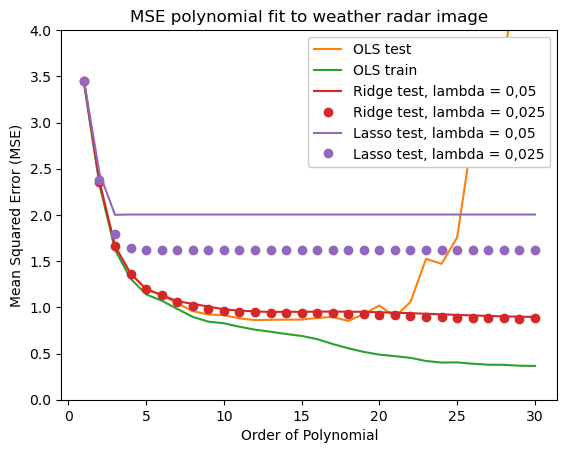

In [82]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_OLS, 'C1', label='OLS test')
plt.plot(range(1, len(MSE_train)+1), expected_MSE_train_OLS, 'C2', label='OLS train')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Ridge, 'C3', label='Ridge test, lambda = 0,05')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Ridge_l, 'C3o', label='Ridge test, lambda = 0,025')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Lasso, 'C4', label='Lasso test, lambda = 0,05')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Lasso_l, 'C4o', label='Lasso test, lambda = 0,025')
plt.legend(loc='upper right', framealpha=1)
plt.xlabel('Order of Polynomial')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE polynomial fit to weather radar image')
plt.ylim(0, 4)
plt.show()

## Plot expected beta for different polynomials with Lasso, Ridge and OLS

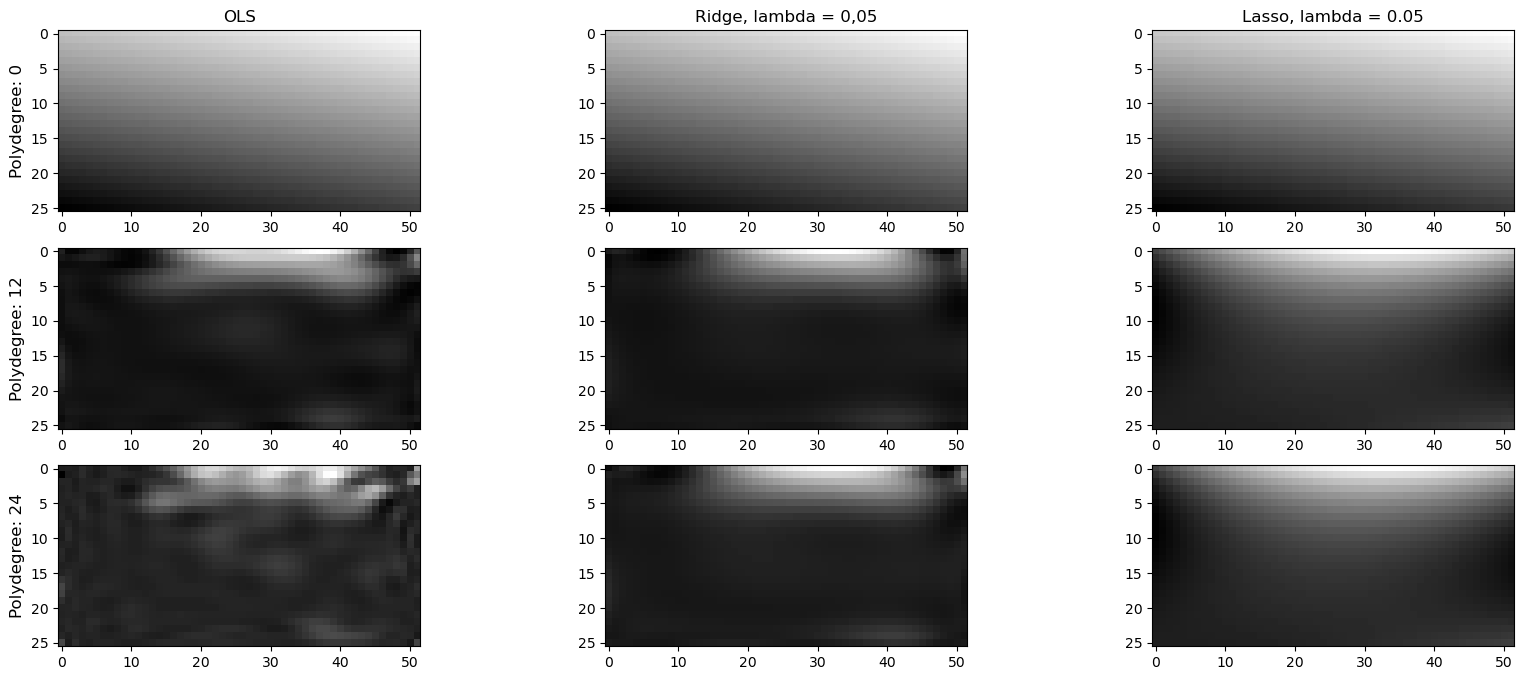

In [109]:
# Recreate terrain
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 3, figsize=(20, 8), facecolor='w', edgecolor='k') #15 25figsize=(20, 8),
for p_number in range(0, len(mean_betas_OLS), 12):
    optimal_beta_OLS = mean_betas_OLS[p_number][~np.isnan(mean_betas_OLS[p_number])]
    optimal_beta_Ridge = mean_betas_Ridge[p_number][~np.isnan(mean_betas_Ridge[p_number])]
    optimal_beta_Lasso = mean_betas_Lasso[p_number][~np.isnan(mean_betas_Lasso[p_number])]

    p_OLS = int((-1 + np.sqrt(1 + 4*2*len(optimal_beta_OLS)))/2) - 1
    # Fit a new polynomial using optimal beta: 
    M = np.zeros([len(x.ravel()), int((p_OLS+1)*(p_OLS+2)/2)])
    c = 0
    x_ = x_cent.ravel()
    y_ = y_cent.ravel()
    for j in range(0, p_OLS+1): # y**j
        for i in range(0, p_OLS+1 -j): # x **i
            M[:, c] = (x_**i)*(y_**j)
            c += 1

    #Polynomial features stacks design matrix in a different order:
    M_Lasso = np.zeros([len(x.ravel()), int((p_OLS+1)*(p_OLS+2)/2)])
    c = 0
    for i in range(0, p_OLS+1): # x**i
        for j in range(0, i+1): # y **i
            M_Lasso[:, c] = (x_**(i - j))*(y_**j) # traverse diagonal
            c += 1
            
    z_pred_OLS = (M @ optimal_beta_OLS).reshape(z.shape)
    z_pred_Ridge = (M @ optimal_beta_Ridge).reshape(z.shape)
    z_pred_Lasso = (M_Lasso @ optimal_beta_Lasso).reshape(z.shape)

    #Plot:
    axs[int(p_number/12), 0].imshow(z_pred_OLS, cmap='gray')
    axs[int(p_number/12), 1].imshow(z_pred_Ridge, cmap='gray')
    axs[int(p_number/12), 2].imshow(z_pred_Lasso, cmap='gray')
    axs[int(p_number/12), 0].set_ylabel('Polydegree: ' + str(p_number), fontsize=12)
    
axs[0, 0].set_title('OLS')
axs[0, 1].set_title('Ridge, lambda = 0,05')
axs[0, 2].set_title('Lasso, lambda = 0.05')
plt.show()

In [88]:
int(p_number/12)

2